# Covid Mortality Rate Across America

I am interested in finding out how significantly Covid-19 impacted different parts of the U.S. To do this, I've collected three datasets. The first one, which I will name 'age' contains the population age distribution for each county in the U.S. The second one, which is called 'master' contains a variety of other information for the same counties. The third dataframe, which I will call 'covid' contains time-series data of cumulative covid deaths for an approximately 13 month range. Using this data, I will be able to derive and visualize metrics that allow me to see COVID's impact across the nation. 

In [1193]:
import numpy as np
import pandas as pd 
import os

In [1194]:
age = pd.read_csv('/Users/manishrathor/Downloads/county_age_dist.csv')
master = pd.read_csv('/Users/manishrathor/Downloads/county_fips_master.csv', encoding = 'latin-1')
covid = pd.read_csv('/Users/manishrathor/Downloads/time_series_covid19_deaths_US.csv')

## Part 1: Data Pre-Processing

## Age Dataset

In [1195]:
age.head()

,fips,0-17,18-24,25-34,35-44,45-54,55-64,65-74,75-84,85+
0,1001,25941,11422,12315,13828,14000,12697,9594,5430,1945
1,1003,86587,37568,44133,46730,49675,52405,43252,23262,8854
2,1005,11057,6162,6603,5907,6490,6377,5255,2795,1074
3,1007,9671,5241,5788,5472,6707,5563,4270,2555,638
4,1009,25671,11360,12635,13570,14737,14123,12106,6560,2022


In [1196]:
age.shape

(3220, 10)

In [1197]:
age.tail()

,fips,0-17,18-24,25-34,35-44,45-54,55-64,65-74,75-84,85+
3215,72145,27016,14455,14882,14168,15026,14450,11928,6139,3159
3216,72147,4724,2727,2092,2356,2496,2972,2364,1498,479
3217,72149,11353,6431,5521,5319,5788,6228,4631,2218,859
3218,72151,16068,9025,8465,9199,9548,9805,7926,3784,2103
3219,72153,17375,8974,9422,9457,10028,10672,8571,4620,2346


Our first step is to standardize the 'fips' column so that all fips values contain five digits. For context, the fips code is a unique identifier that every county in the U.S. is assigned.

In [1198]:
type(age['fips'][1])

numpy.int64

In [1199]:
age['fips'] = age['fips'].astype(str)
age['fips'] = age['fips'].str.zfill(5)
age.set_index('fips', inplace = True)
age.head()

,0-17,18-24,25-34,35-44,45-54,55-64,65-74,75-84,85+
fips,,,,,,,,,
01001,25941,11422,12315,13828,14000,12697,9594,5430,1945
01003,86587,37568,44133,46730,49675,52405,43252,23262,8854
01005,11057,6162,6603,5907,6490,6377,5255,2795,1074
01007,9671,5241,5788,5472,6707,5563,4270,2555,638
01009,25671,11360,12635,13570,14737,14123,12106,6560,2022


I will now find the total population for each county, and the ratio of each age distribution relative to that total population.

In [1200]:
# finding the population of each county
age['Population'] = age.iloc[:,:].sum(axis = 1) 
age.head()

,0-17,18-24,25-34,35-44,45-54,55-64,65-74,75-84,85+,Population
fips,,,,,,,,,,
01001,25941,11422,12315,13828,14000,12697,9594,5430,1945,107172
01003,86587,37568,44133,46730,49675,52405,43252,23262,8854,392466
01005,11057,6162,6603,5907,6490,6377,5255,2795,1074,51720
01007,9671,5241,5788,5472,6707,5563,4270,2555,638,45905
01009,25671,11360,12635,13570,14737,14123,12106,6560,2022,112784


In [1201]:
# finding the proportion of each age group in each county
age_bins = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64','65-74', '75-84', '85+']

for bins in age_bins:
    column = f'{bins}_ratio'
    age[column] = age[f'{bins}'] / age['Population']

age.head()

,0-17,18-24,25-34,35-44,45-54,55-64,65-74,75-84,85+,Population,0-17_ratio,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio
fips,,,,,,,,,,,,,,,,,,,
01001,25941,11422,12315,13828,14000,12697,9594,5430,1945,107172,0.242050,0.106576,0.114909,0.129026,0.130631,0.118473,0.089520,0.050666,0.018148
01003,86587,37568,44133,46730,49675,52405,43252,23262,8854,392466,0.220623,0.095723,0.112451,0.119068,0.126571,0.133527,0.110206,0.059271,0.022560
01005,11057,6162,6603,5907,6490,6377,5255,2795,1074,51720,0.213786,0.119142,0.127668,0.114211,0.125483,0.123299,0.101605,0.054041,0.020766
01007,9671,5241,5788,5472,6707,5563,4270,2555,638,45905,0.210674,0.114171,0.126086,0.119203,0.146106,0.121185,0.093018,0.055658,0.013898
01009,25671,11360,12635,13570,14737,14123,12106,6560,2022,112784,0.227612,0.100724,0.112028,0.120318,0.130666,0.125222,0.107338,0.058164,0.017928


In [1202]:
# ensuring that the proportions sum to 1
age.loc[:,'0-17_ratio':].sum(axis = 1).head()

fips
01001    1.0
01003    1.0
01005    1.0
01007    1.0
01009    1.0
dtype: float64

In [1203]:
# checking for missing data
age.isnull().sum().sum()

0

## Master Dataset

I'm going to merge the age and master dataset to view relevant data from both sets in one dataset.

In [1204]:
master.head()

,fips,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
0,1001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
1,1003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
2,1005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
3,1007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
4,1009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central


In [1205]:
type(master['fips'][1])

numpy.int64

In [1206]:
master['fips'] = master['fips'].astype(str)
master['fips'] = master['fips'].str.zfill(5)
master.set_index('fips', inplace = True)
master.head()

,county_name,state_abbr,state_name,long_name,sumlev,region,division,state,county,crosswalk,region_name,division_name
fips,,,,,,,,,,,,
01001,Autauga County,AL,Alabama,Autauga County AL,50.0,3.0,6.0,1.0,1.0,3-6-1-1,South,East South Central
01003,Baldwin County,AL,Alabama,Baldwin County AL,50.0,3.0,6.0,1.0,3.0,3-6-1-3,South,East South Central
01005,Barbour County,AL,Alabama,Barbour County AL,50.0,3.0,6.0,1.0,5.0,3-6-1-5,South,East South Central
01007,Bibb County,AL,Alabama,Bibb County AL,50.0,3.0,6.0,1.0,7.0,3-6-1-7,South,East South Central
01009,Blount County,AL,Alabama,Blount County AL,50.0,3.0,6.0,1.0,9.0,3-6-1-9,South,East South Central


This dataset contains mostly geographic info about the counties. I'm going to keep the 'county_name', 'state_name', and 'region_name' columns. The rest of the data will not help me in my analysis. 

In [1207]:
master = master[['county_name', 'state_name', 'region_name']]
master = master.rename(columns = {'county_name': 'County', 'state_name': 'State', 'region_name': 'Region'})
master.head()

,County,State,Region
fips,,,
01001,Autauga County,Alabama,South
01003,Baldwin County,Alabama,South
01005,Barbour County,Alabama,South
01007,Bibb County,Alabama,South
01009,Blount County,Alabama,South


In [1208]:
# checking for missing data
print(master.isnull().sum().sum())
print(master.isnull().sum())
np.where(master['Region'].isnull())


3
County    0
State     0
Region    3
dtype: int64


(array([  93, 2420, 2919]),)

In [1209]:
# removing missing data
master.dropna(inplace = True)
print(master.isnull().sum().sum())

0


Both datasets are clean now so we can prepare to merge them

In [1210]:
print(age.shape)
print(master.shape)

(3220, 19)
(3143, 3)


We should merge by the index, and by the master dataset. That way, we won't have missing data - as the master dataset is smaller. 

In [1211]:
merged = pd.merge(master, age, how = 'inner', left_index = True, right_index = True)
print(merged.shape)
merged.head()

(3143, 22)


,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,65-74,...,Population,0-17_ratio,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio
fips,,,,,,,,,,,,,,,,,,,,,
01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,9594,...,107172,0.242050,0.106576,0.114909,0.129026,0.130631,0.118473,0.089520,0.050666,0.018148
01003,Baldwin County,Alabama,South,86587,37568,44133,46730,49675,52405,43252,...,392466,0.220623,0.095723,0.112451,0.119068,0.126571,0.133527,0.110206,0.059271,0.022560
01005,Barbour County,Alabama,South,11057,6162,6603,5907,6490,6377,5255,...,51720,0.213786,0.119142,0.127668,0.114211,0.125483,0.123299,0.101605,0.054041,0.020766
01007,Bibb County,Alabama,South,9671,5241,5788,5472,6707,5563,4270,...,45905,0.210674,0.114171,0.126086,0.119203,0.146106,0.121185,0.093018,0.055658,0.013898
01009,Blount County,Alabama,South,25671,11360,12635,13570,14737,14123,12106,...,112784,0.227612,0.100724,0.112028,0.120318,0.130666,0.125222,0.107338,0.058164,0.017928


In [1212]:
# ensuring that there is no missing data
merged.isnull().sum().sum()

0

## Covid Dataset

In [1213]:
print(covid.shape)
covid.head()

(3340, 413)


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,84,84,84,85,85,85,85,84,85,89
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,253,253,254,262,262,262,262,263,272,274
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,48,49,49,49,50,50,50,50,50,51
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,57,57,57,58,58,58,58,59,59,60
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,121,121,121,125,125,125,125,125,125,125


In [1214]:
# removing missing data
print(covid.isnull().sum().sum())
covid.dropna(inplace = True)
print(covid.isnull().sum().sum())
covid.shape

16
0


(3324, 413)

In [1215]:
# Standardizing fips column and converting it to index
covid['FIPS'] = covid['FIPS'].round().astype(int)
covid['FIPS'] = covid['FIPS'].astype(str)
covid.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21
0,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,...,84,84,84,85,85,85,85,84,85,89
1,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,...,253,253,254,262,262,262,262,263,272,274
2,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,...,48,49,49,49,50,50,50,50,50,51
3,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,...,57,57,57,58,58,58,58,59,59,60
4,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,...,121,121,121,125,125,125,125,125,125,125


In [1216]:
print(type(covid['FIPS'][1]))
covid['FIPS'] = covid['FIPS'].str.zfill(5)
covid = covid.rename(columns = {'FIPS': 'fips'})
covid.set_index('fips', inplace = True)
covid.head()

<class 'str'>


,UID,iso2,iso3,code3,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21
fips,,,,,,,,,,,,,,,,,,,,,
01001,84001001,US,USA,840,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",...,84,84,84,85,85,85,85,84,85,89
01003,84001003,US,USA,840,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",...,253,253,254,262,262,262,262,263,272,274
01005,84001005,US,USA,840,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",...,48,49,49,49,50,50,50,50,50,51
01007,84001007,US,USA,840,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",...,57,57,57,58,58,58,58,59,59,60
01009,84001009,US,USA,840,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",...,121,121,121,125,125,125,125,125,125,125


All of the identifiers (other than fips) are unnecessary because they exist in the dataset I will merge this with. I'll keep the fips column as the index to use it as the merge key.

In [1217]:
# removing unnecessary columns
covid = covid.drop(['UID', 'iso2', 'iso3', 'code3', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key', 'Population'], axis = 1)
covid.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21
fips,,,,,,,,,,,,,,,,,,,,,
01001,0,0,0,0,0,0,0,0,0,0,...,84,84,84,85,85,85,85,84,85,89
01003,0,0,0,0,0,0,0,0,0,0,...,253,253,254,262,262,262,262,263,272,274
01005,0,0,0,0,0,0,0,0,0,0,...,48,49,49,49,50,50,50,50,50,51
01007,0,0,0,0,0,0,0,0,0,0,...,57,57,57,58,58,58,58,59,59,60
01009,0,0,0,0,0,0,0,0,0,0,...,121,121,121,125,125,125,125,125,125,125


In [1218]:
print(covid.shape)
print(merged.shape)

(3324, 401)
(3143, 22)


In [1219]:
# merging the dataframes
merged = pd.merge(merged, covid, how = 'inner', left_index = True, right_index = True)
print(merged.shape)
#checking for missing data
merged.isnull().sum().sum()

(3143, 423)


0

In [1220]:
merged.head()

,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,65-74,...,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21
fips,,,,,,,,,,,,,,,,,,,,,
01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,9594,...,84,84,84,85,85,85,85,84,85,89
01003,Baldwin County,Alabama,South,86587,37568,44133,46730,49675,52405,43252,...,253,253,254,262,262,262,262,263,272,274
01005,Barbour County,Alabama,South,11057,6162,6603,5907,6490,6377,5255,...,48,49,49,49,50,50,50,50,50,51
01007,Bibb County,Alabama,South,9671,5241,5788,5472,6707,5563,4270,...,57,57,57,58,58,58,58,59,59,60
01009,Blount County,Alabama,South,25671,11360,12635,13570,14737,14123,12106,...,121,121,121,125,125,125,125,125,125,125


Let's convert the data to long format so it can be visualized correctly. We want to have columns for date, county, state, region, age distributions, age ratios, and population

In [1221]:
merged.reset_index(inplace = True)


In [1222]:
merged.loc[:,'fips':'85+_ratio']

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,Population,0-17_ratio,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio
0,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,107172,0.242050,0.106576,0.114909,0.129026,0.130631,0.118473,0.089520,0.050666,0.018148
1,01003,Baldwin County,Alabama,South,86587,37568,44133,46730,49675,52405,...,392466,0.220623,0.095723,0.112451,0.119068,0.126571,0.133527,0.110206,0.059271,0.022560
2,01005,Barbour County,Alabama,South,11057,6162,6603,5907,6490,6377,...,51720,0.213786,0.119142,0.127668,0.114211,0.125483,0.123299,0.101605,0.054041,0.020766
3,01007,Bibb County,Alabama,South,9671,5241,5788,5472,6707,5563,...,45905,0.210674,0.114171,0.126086,0.119203,0.146106,0.121185,0.093018,0.055658,0.013898
4,01009,Blount County,Alabama,South,25671,11360,12635,13570,14737,14123,...,112784,0.227612,0.100724,0.112028,0.120318,0.130666,0.125222,0.107338,0.058164,0.017928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,Sweetwater County,Wyoming,West,23585,10054,12947,11059,10274,11402,...,90261,0.261298,0.111388,0.143440,0.122522,0.113825,0.126323,0.068867,0.037358,0.014979
3139,56039,Teton County,Wyoming,West,10052,3499,8893,6979,6358,6422,...,48950,0.205352,0.071481,0.181675,0.142574,0.129888,0.131195,0.085066,0.032543,0.020225
3140,56041,Uinta County,Wyoming,West,12045,4634,5291,5669,4979,5801,...,44225,0.272357,0.104782,0.119638,0.128185,0.112583,0.131170,0.080136,0.032945,0.018202
3141,56043,Washakie County,Wyoming,West,3847,1441,1815,1804,2020,2350,...,16781,0.229247,0.085871,0.108158,0.107503,0.120374,0.140039,0.109290,0.068709,0.030809


In [1223]:
id_columns = merged.columns[(merged.columns.get_loc('fips')):(merged.columns.get_loc('85+_ratio') + 1)]
id_columns

Index(['fips', 'County', 'State', 'Region', '0-17', '18-24', '25-34', '35-44',
       '45-54', '55-64', '65-74', '75-84', '85+', 'Population', '0-17_ratio',
       '18-24_ratio', '25-34_ratio', '35-44_ratio', '45-54_ratio',
       '55-64_ratio', '65-74_ratio', '75-84_ratio', '85+_ratio'],
      dtype='object')

In [1224]:
# converting to long format
tidy = pd.melt(merged, id_vars = id_columns, var_name = 'Date', value_name = 'Deaths')
tidy.head()

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Deaths
0,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.089520,0.050666,0.018148,1/22/20,0
1,01003,Baldwin County,Alabama,South,86587,37568,44133,46730,49675,52405,...,0.095723,0.112451,0.119068,0.126571,0.133527,0.110206,0.059271,0.022560,1/22/20,0
2,01005,Barbour County,Alabama,South,11057,6162,6603,5907,6490,6377,...,0.119142,0.127668,0.114211,0.125483,0.123299,0.101605,0.054041,0.020766,1/22/20,0
3,01007,Bibb County,Alabama,South,9671,5241,5788,5472,6707,5563,...,0.114171,0.126086,0.119203,0.146106,0.121185,0.093018,0.055658,0.013898,1/22/20,0
4,01009,Blount County,Alabama,South,25671,11360,12635,13570,14737,14123,...,0.100724,0.112028,0.120318,0.130666,0.125222,0.107338,0.058164,0.017928,1/22/20,0


In [1225]:
tidy = tidy.rename(columns = {'Deaths':'Cumulative Deaths'})
tidy.head()

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Cumulative Deaths
0,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.089520,0.050666,0.018148,1/22/20,0
1,01003,Baldwin County,Alabama,South,86587,37568,44133,46730,49675,52405,...,0.095723,0.112451,0.119068,0.126571,0.133527,0.110206,0.059271,0.022560,1/22/20,0
2,01005,Barbour County,Alabama,South,11057,6162,6603,5907,6490,6377,...,0.119142,0.127668,0.114211,0.125483,0.123299,0.101605,0.054041,0.020766,1/22/20,0
3,01007,Bibb County,Alabama,South,9671,5241,5788,5472,6707,5563,...,0.114171,0.126086,0.119203,0.146106,0.121185,0.093018,0.055658,0.013898,1/22/20,0
4,01009,Blount County,Alabama,South,25671,11360,12635,13570,14737,14123,...,0.100724,0.112028,0.120318,0.130666,0.125222,0.107338,0.058164,0.017928,1/22/20,0


We also want to remove any counties with a population of zero, as that will skew the statistics we generate.

In [1226]:
print(tidy.shape)
tidy = tidy[tidy['Population'] != 0]
print(tidy.shape)

(1260343, 25)
(1260343, 25)


I'll convert the date to a datetime type (because it makes visualization possible), and I'll sort the dataset so we group counties together in chronological order.

In [1227]:
tidy['Date'] = pd.to_datetime(tidy['Date'])
tidy.sort_values(by = ['fips', 'Date'], inplace = True)
tidy.head()

/var/folders/4c/kfn9rtts2x54cchws5wfz9h40000gn/T/ipykernel_99331/3196163624.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,18-24_ratio,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Cumulative Deaths
0,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-22,0
3143,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-23,0
6286,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-24,0
9429,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-25,0
12572,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.106576,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-26,0


I will find the number of daily deaths per county, as cumulative deaths do not give us much information on Covid's impact over time.

In [1228]:
tidy['Daily Deaths'] = tidy.groupby('fips')['Cumulative Deaths'].transform(lambda x: x.diff())
tidy.fillna(0, inplace = True)
tidy.head()

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Cumulative Deaths,Daily Deaths
0,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-22,0,0.0
3143,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-23,0,0.0
6286,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-24,0,0.0
9429,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-25,0,0.0
12572,01001,Autauga County,Alabama,South,25941,11422,12315,13828,14000,12697,...,0.114909,0.129026,0.130631,0.118473,0.08952,0.050666,0.018148,2020-01-26,0,0.0


In [1229]:
tidy[tidy['County'] == 'Yolo County'].tail()

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,25-34_ratio,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Cumulative Deaths,Daily Deaths
1244870,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.125201,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-21,181,0.0
1248013,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.125201,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-22,181,0.0
1251156,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.125201,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-23,185,4.0
1254299,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.125201,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-24,185,0.0
1257442,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.125201,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-25,185,0.0


The metric we will use to visualize Covid's impact is the incidence proportion per 100,000 people. The formula for incidence proportion is (daily deaths/population) * n, where n is an arbitrary number. In our case we select n to be 100,000. We apply this transformation because counties with small populations will naturally have lower death counts, while larger counties will have higher counts. This may cause investigators to assume that certain counties handled the pandemic more/less effectively than they actually did, because they don't account for the fact that small counties simply have less people - leading to less deaths, while large counties have large populations - leading to more deaths. Using the incidence proportion will find the number of expected deaths for each county, if each county had a population of 100,000. Transforming each county to the same population will alleviate any skew.

In [1230]:
tidy['Incidence Proportion'] = tidy['Daily Deaths'] / tidy['Population'] * 100000
tidy[tidy['County'] == 'Yolo County'].tail()

,fips,County,State,Region,0-17,18-24,25-34,35-44,45-54,55-64,...,35-44_ratio,45-54_ratio,55-64_ratio,65-74_ratio,75-84_ratio,85+_ratio,Date,Cumulative Deaths,Daily Deaths,Incidence Proportion
1244870,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-21,181,0.0,0.000000
1248013,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-22,181,0.0,0.000000
1251156,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-23,185,4.0,0.985819
1254299,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-24,185,0.0,0.000000
1257442,06113,Yolo County,California,West,85895,81979,50801,44740,43509,43224,...,0.110264,0.10723,0.106528,0.074348,0.041557,0.021138,2021-02-25,185,0.0,0.000000


Much of the data in the dataset is unnecessary, so I will create a new dataset that only contains necessary information.

In [1231]:
tidyf = tidy[['fips', 'County', 'State', 'Region', 'Population', 'Date', 'Cumulative Deaths', 'Daily Deaths', 'Incidence Proportion']]
tidyf[tidyf['County'] == 'Yolo County'].tail()

,fips,County,State,Region,Population,Date,Cumulative Deaths,Daily Deaths,Incidence Proportion
1244870,06113,Yolo County,California,West,405754,2021-02-21,181,0.0,0.000000
1248013,06113,Yolo County,California,West,405754,2021-02-22,181,0.0,0.000000
1251156,06113,Yolo County,California,West,405754,2021-02-23,185,4.0,0.985819
1254299,06113,Yolo County,California,West,405754,2021-02-24,185,0.0,0.000000
1257442,06113,Yolo County,California,West,405754,2021-02-25,185,0.0,0.000000


In [1232]:
# sorting the dataframe and turning the fips code into the index
tidyf.sort_values(by = ['fips', 'Date'], inplace = True)
tidyf = tidyf.reset_index(drop = True)
tidyf.head()

/var/folders/4c/kfn9rtts2x54cchws5wfz9h40000gn/T/ipykernel_99331/1887379830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,fips,County,State,Region,Population,Date,Cumulative Deaths,Daily Deaths,Incidence Proportion
0,01001,Autauga County,Alabama,South,107172,2020-01-22,0,0.0,0.0
1,01001,Autauga County,Alabama,South,107172,2020-01-23,0,0.0,0.0
2,01001,Autauga County,Alabama,South,107172,2020-01-24,0,0.0,0.0
3,01001,Autauga County,Alabama,South,107172,2020-01-25,0,0.0,0.0
4,01001,Autauga County,Alabama,South,107172,2020-01-26,0,0.0,0.0


In [1233]:
# checking for negative incidence proportions - which shouldn't exist
tidyf[tidyf['Incidence Proportion'] < 0]

,fips,County,State,Region,Population,Date,Cumulative Deaths,Daily Deaths,Incidence Proportion
89,01001,Autauga County,Alabama,South,107172,2020-04-20,1,-1.0,-0.933080
100,01001,Autauga County,Alabama,South,107172,2020-05-01,3,-1.0,-0.933080
119,01001,Autauga County,Alabama,South,107172,2020-05-20,3,-1.0,-0.933080
254,01001,Autauga County,Alabama,South,107172,2020-10-02,27,-1.0,-0.933080
289,01001,Autauga County,Alabama,South,107172,2020-11-06,30,-1.0,-0.933080
...,...,...,...,...,...,...,...,...,...
1256210,56025,Natrona County,Wyoming,West,153493,2020-10-26,8,-1.0,-0.651496
1256282,56025,Natrona County,Wyoming,West,153493,2021-01-06,96,-1.0,-0.651496
1259124,56039,Teton County,Wyoming,West,48950,2021-02-10,8,-1.0,-2.042901
1260233,56045,Weston County,Wyoming,West,13640,2020-11-08,0,-1.0,-7.331378


We can see that there are a significant number of rows with negative daily deaths, implying that there are decreasing cumulative deaths. This is not possible, so we'll remove the rows with this issue.

In [1234]:
tidyf.shape

(1260343, 9)

In [1235]:
tidyf = tidyf[tidyf['Incidence Proportion'] >= 0]
tidyf.shape

(1256295, 9)

To effectively show Covid's Impact in different parts of the country, we will group the data by region.

In [1236]:
tidyf.groupby('Region').mean(numeric_only = True)

,Population,Cumulative Deaths,Daily Deaths,Incidence Proportion
Region,,,,
Midwest,124217.452035,31.729971,0.246031,0.246329
Northeast,513081.143763,271.933929,1.423273,0.201856
South,166231.704590,39.280336,0.325148,0.245405
West,323889.207045,57.220226,0.533793,0.143535


In [1237]:
tidyf['Date'] = tidyf['Date'].apply(pd.to_datetime)
type(tidyf['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

We will find the mean incidence proportion per day for each region, which will allow us to effectively visualize our data.

In [1238]:
tidyfviz = tidyf.groupby(['Date', 'Region'], as_index = False)['Incidence Proportion'].mean()
tidyfviz.head()

,Date,Region,Incidence Proportion
0,2020-01-22,Midwest,0.0
1,2020-01-22,Northeast,0.0
2,2020-01-22,South,0.0
3,2020-01-22,West,0.0
4,2020-01-23,Midwest,0.0


In [1239]:
tidyfviz['Date'] = tidyfviz['Date'].apply(pd.to_datetime)

## Part 2: Data Visualization

In [1240]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

## Line Plots

I will now create the x and y values for our line plots. Because this is time-series data, the x-values will be dates, and the y-values will be the mean incidence proportion per region

I'll subset the data by region, and use the dates and incidence proportions for each regions for each respective visual. 

Also, because the data contains a significant amount of variance, using raw incidence proportions will result in ineffective visualizations. Therefore, I will apply the savistky_golay filter to the incidence proportion values, which will smooth the data.

In [1241]:
# creating the x-values for each region
xne = tidyfviz[tidyfviz['Region'] == 'Northeast']['Date']
xs = tidyfviz[tidyfviz['Region'] == 'South']['Date']
xw = tidyfviz[tidyfviz['Region'] == 'West']['Date']
xm = tidyfviz[tidyfviz['Region'] == 'Midwest']['Date']

In [1242]:
# creating the raw y-values for each region
yne = tidyfviz[tidyfviz['Region'] == 'Northeast']['Incidence Proportion']
ys = tidyfviz[tidyfviz['Region'] == 'South']['Incidence Proportion']
yw = tidyfviz[tidyfviz['Region'] == 'West']['Incidence Proportion']
ym = tidyfviz[tidyfviz['Region'] == 'Midwest']['Incidence Proportion']

In [1243]:
# smoothing the raw y-values 
ynes = savgol_filter(yne, 51, 3)
ys = savgol_filter(ys, 51, 3)
yw = savgol_filter(yw, 51, 3)
ym = savgol_filter(ym, 51, 3)

I'll use matplotlib to create line plots for each region.

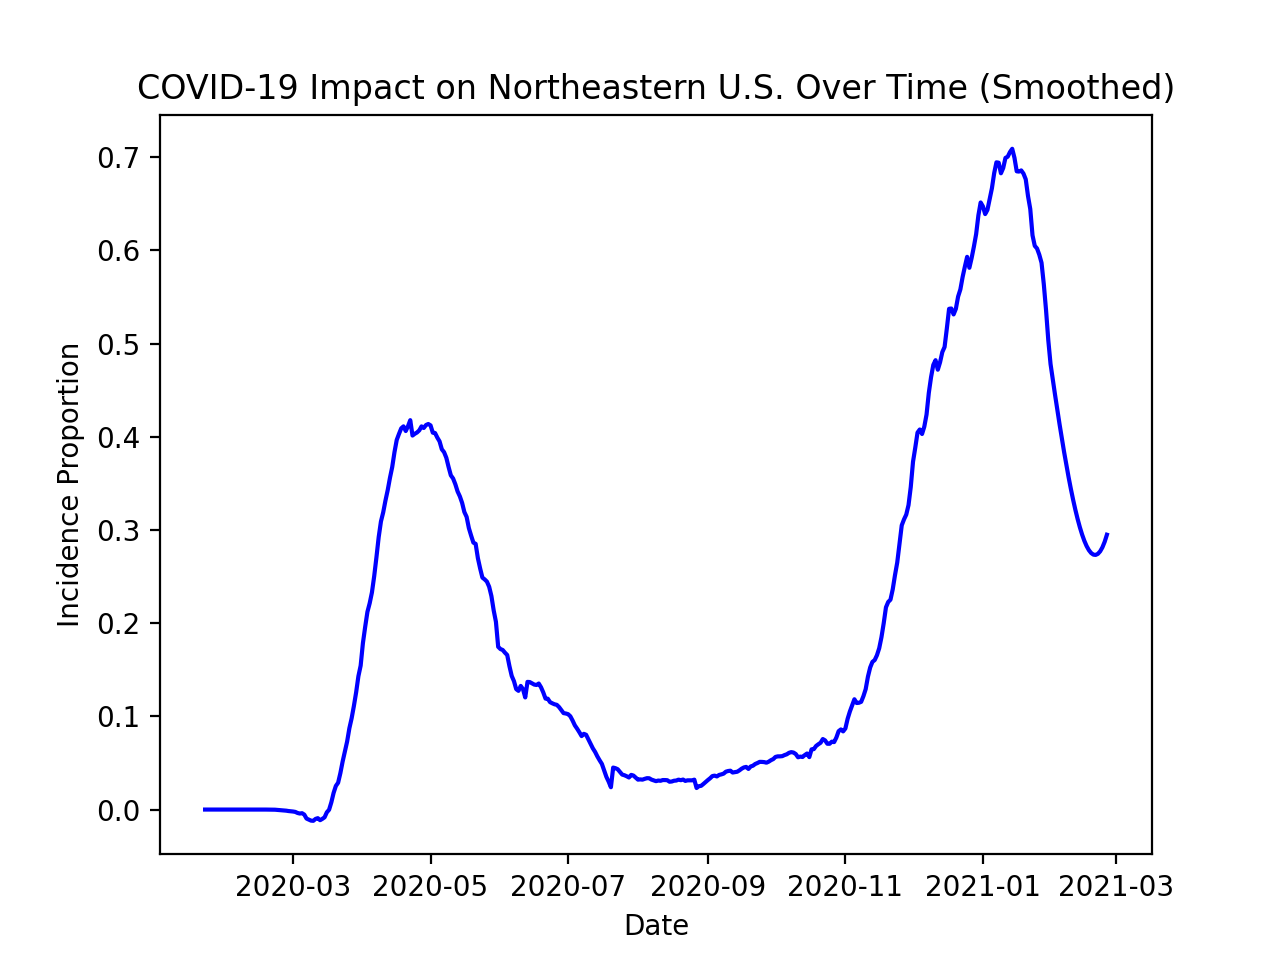

In [1260]:
plt.plot(xne, ynes, color = 'blue')
plt.xlabel('Date')
plt.ylabel('Incidence Proportion')
plt.title('COVID-19 Impact on Northeastern U.S. Over Time (Smoothed)')
plt.show()

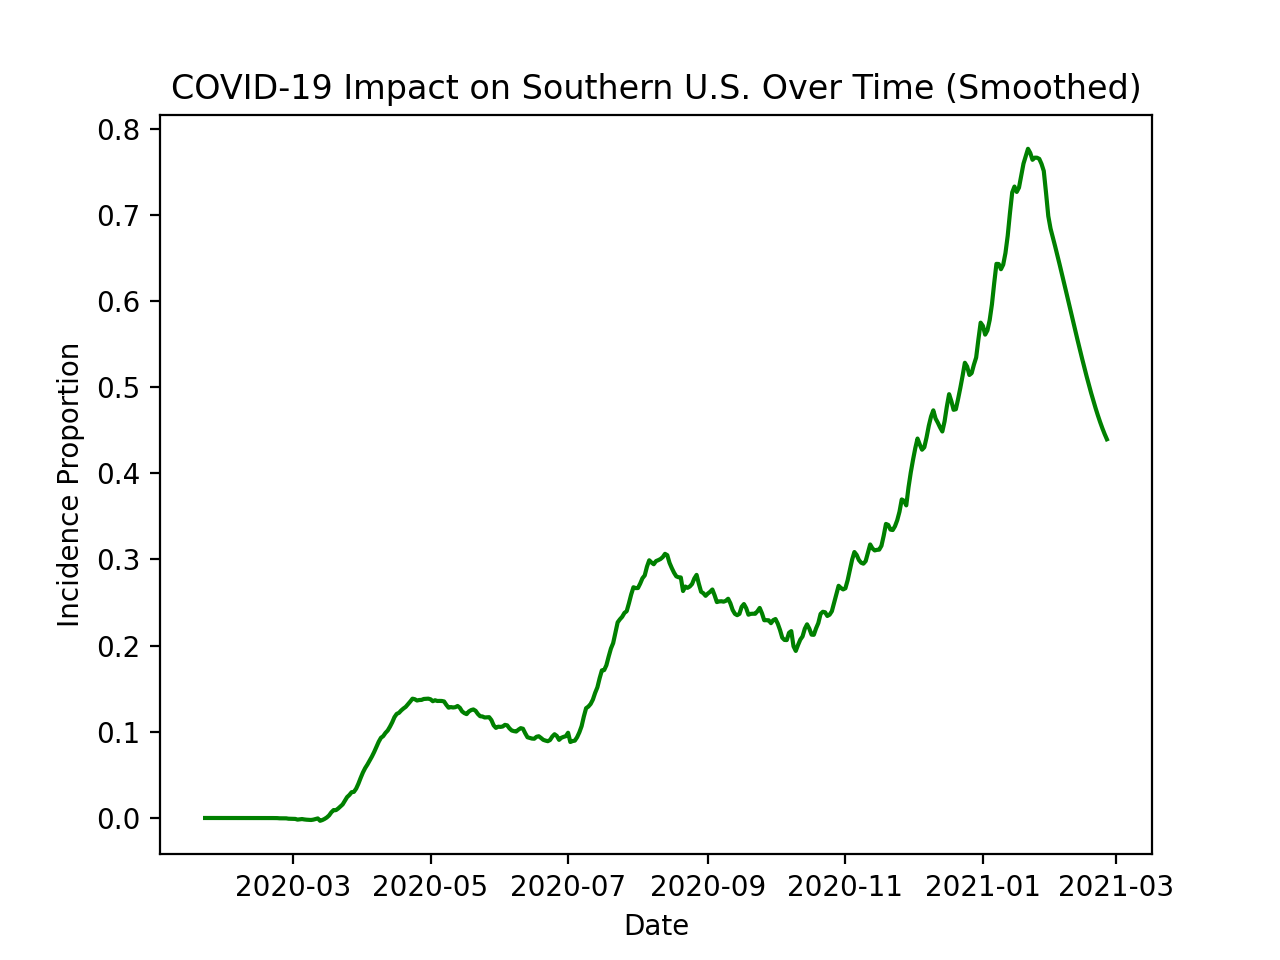

In [1261]:
plt.plot(xs, ys, color = 'green')
plt.xlabel('Date')
plt.ylabel('Incidence Proportion')
plt.title('COVID-19 Impact on Southern U.S. Over Time (Smoothed)')
plt.show()

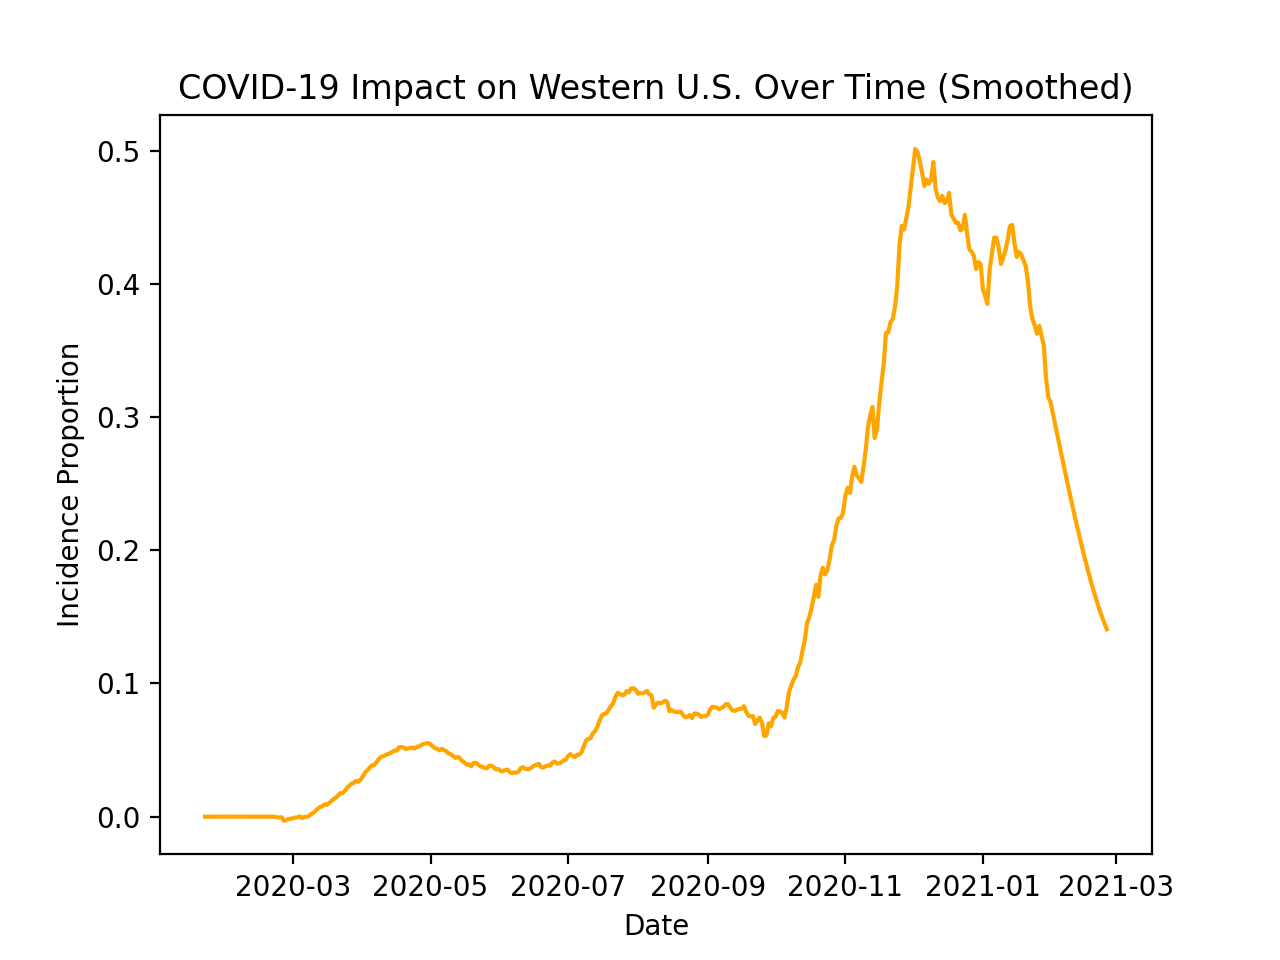

In [1262]:
plt.plot(xw, yw, color = 'orange')
plt.xlabel('Date')
plt.ylabel('Incidence Proportion')
plt.title('COVID-19 Impact on Western U.S. Over Time (Smoothed)')
plt.show()

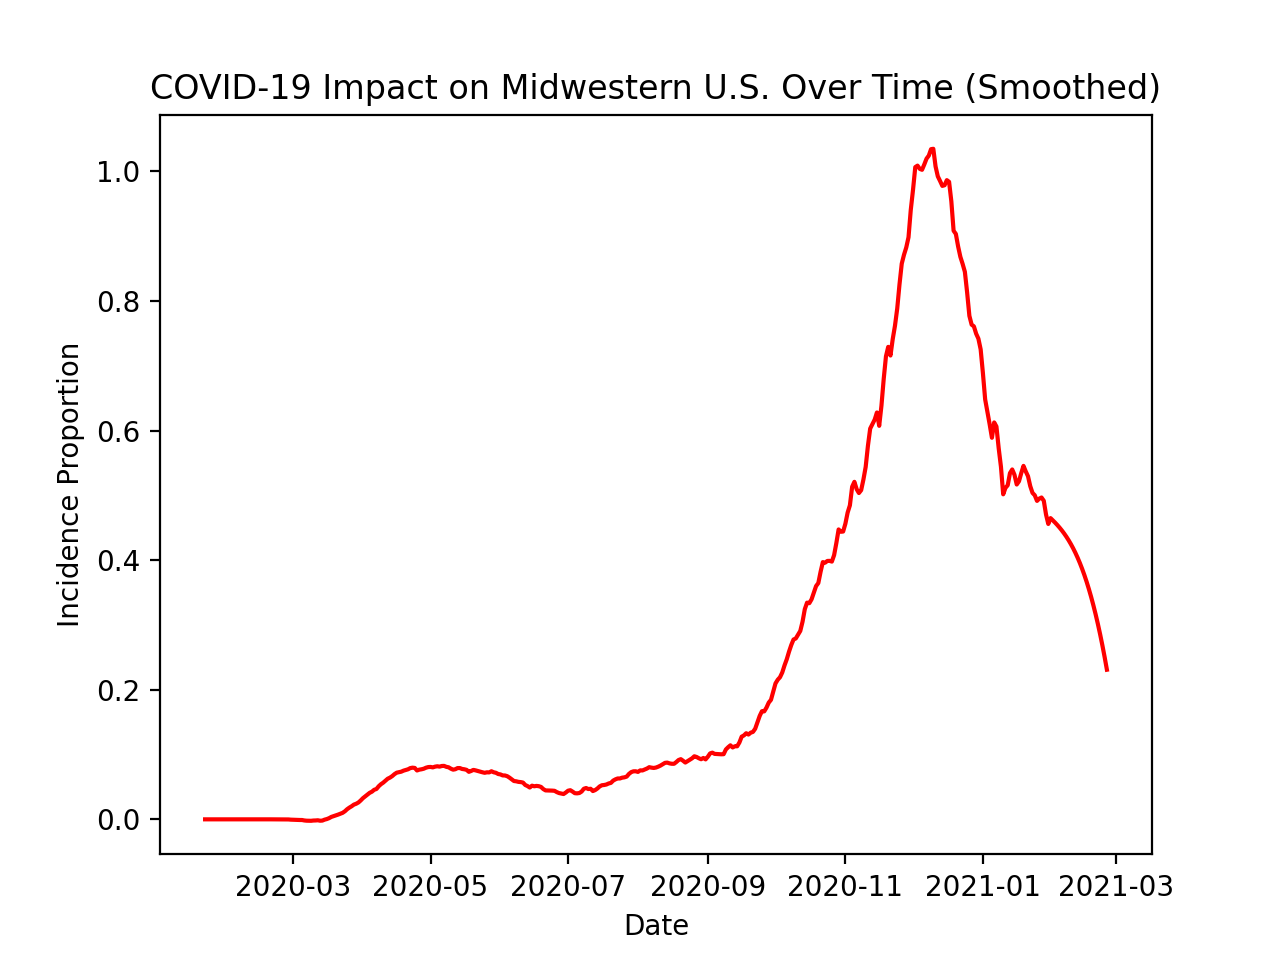

In [1263]:
plt.plot(xm, ym, color = 'red')
plt.xlabel('Date')
plt.ylabel('Incidence Proportion')
plt.title('COVID-19 Impact on Midwestern U.S. Over Time (Smoothed)')
plt.show()

## Boxplots

I will also create a boxplot, which will show a side-by-side comparison of the variance in incidence proportions across regions. Because the incidence proportions are small values, I'll apply a log transformation to create a more effective visualization.

In [1248]:
import seaborn as sns

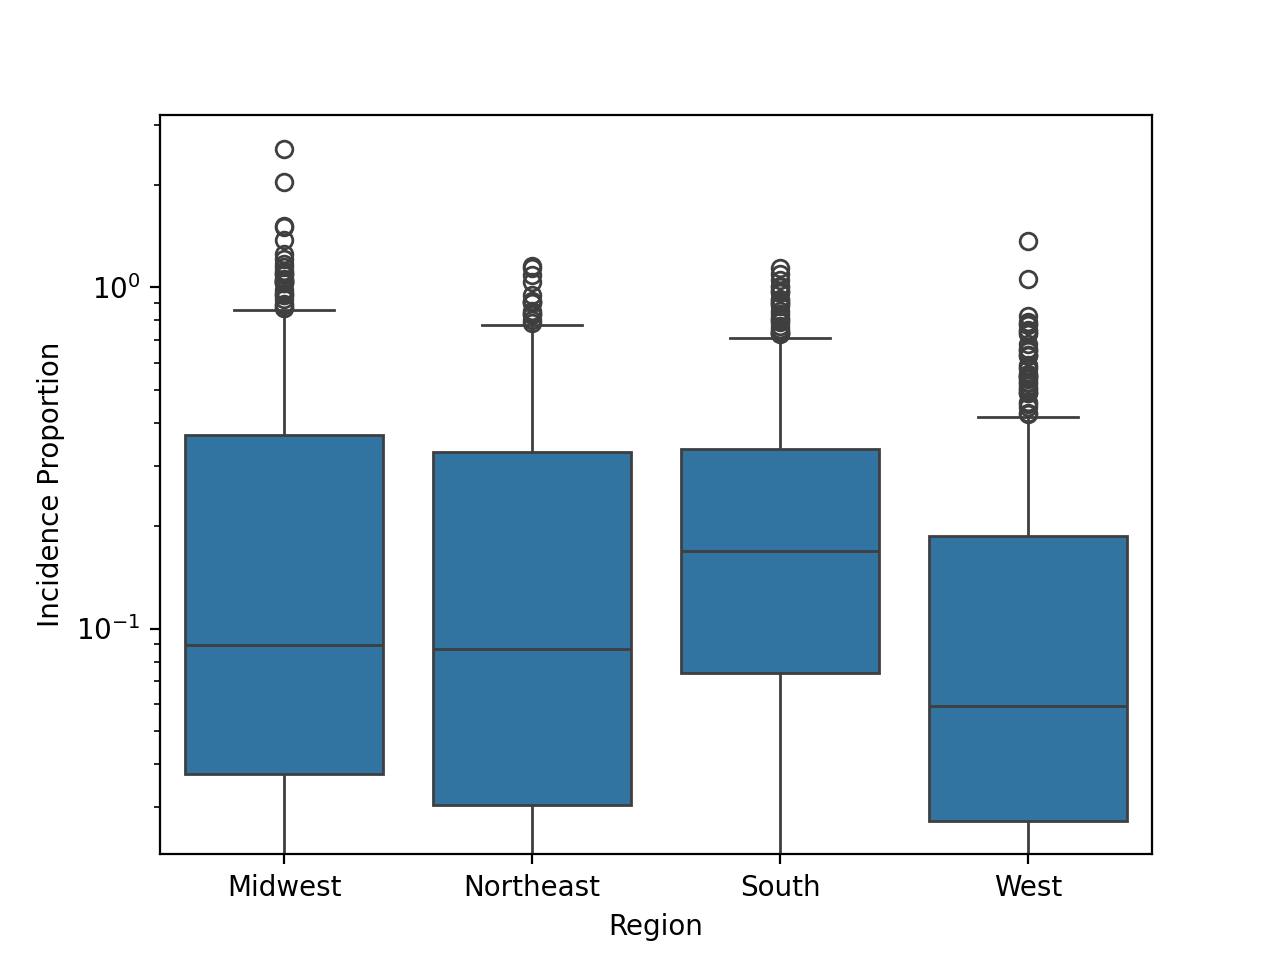

In [1249]:
sns.boxplot(x = 'Region', y = 'Incidence Proportion', data = tidyfviz)
plt.yscale('log')
plt.show()

In [1271]:
# this table shows the overall impact COVID had on the regions
# it shows the mean incidence proportion for each region over the entire time period
tidyfviz.groupby(['Region'])[["Incidence Proportion"]].mean()

,Incidence Proportion
Region,
Midwest,0.246794
Northeast,0.201870
South,0.245841
West,0.143823


## Conclusion - Sort of

We can see from the visualizations that there was a massive spike in COVID-19 deaths aroung January 2021. We can also see that the midwest and northeast had the largest variation, meaning that some counties handled the pandemic effectively, while others did not. While the west, south, and midwest saw similar trends in the rise and fall of cases, the northeast U.S. experience an unprecedented spike around May 2020. Finally, we can see the west handled the pandemic significantly more effectively than the other regions, as their mean incidence proportions were much lower than the rest. 

This data analysis give us important insight into the impact of COVID-19 in the United States. However, there is still more to be investigated. In the future, I will be creating metrics and visualizations that can allow investigators to identify the relationship between age distributions and mortality rates.